In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

### File Train.

In [2]:
train = pd.read_csv("data/train.csv")

In [3]:
train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


We decide to drop these 4 columns because we will use Latitude and Longtitude instead of address
- Address 
- Block 
- Street 
- AddressNumberAndStreet

In [4]:
train.drop(columns=['Address','Block','Street','AddressNumberAndStreet'],inplace=True)

Check null value in train dataframe which is not have any null value

In [5]:
train.isnull().sum()

Date               0
Species            0
Trap               0
Latitude           0
Longitude          0
AddressAccuracy    0
NumMosquitos       0
WnvPresent         0
dtype: int64

### Species
CULEX SALINARIUS, CULEX TARSALIS, CULEX ERRATICUS, CULEX TERRITANS these 4 species of mosquitoes are have least number so we decide to group it as OTHERS  

In [6]:
train['Species'].value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

In [7]:
train['Species'] = train['Species'].map({
    'CULEX PIPIENS/RESTUANS':'CULEX PIPIENS/RESTUANS',
    'CULEX RESTUANS':'CULEX RESTUANS',
    'CULEX PIPIENS':'CULEX PIPIENS',
    'CULEX TERRITANS':'other',
    'CULEX SALINARIUS' : 'other',
    'CULEX TARSALIS':'other',
    'CULEX ERRATICUS':'other'})

In [8]:
train['Species'].value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
other                      315
Name: Species, dtype: int64

### Date
Convert to datetime datatype and split it in day / month / year / weekofyear.<br>
Due to have some hypothesis of weather. Week of year or month must be use as the feature to predict WNVpresent.

In [9]:
train['Date'] = pd.to_datetime(train['Date'])
train['day'] = train['Date'].dt.day
train['month'] = train['Date'].dt.month
train['year'] = train['Date'].dt.year
train['week'] = train['Date'].dt.weekofyear

<ipython-input-9-2cc093a15ba0>:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  train['week'] = train['Date'].dt.weekofyear


Majority of number mosquitos in each trap have a low number.

<AxesSubplot:>

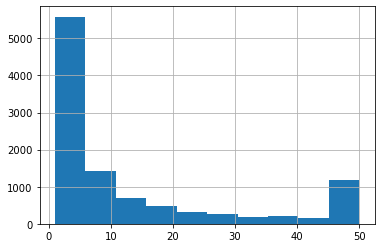

In [10]:
train['NumMosquitos'].hist()

This dataset is quite imbalance we will manage this in modeling part

In [11]:
train['WnvPresent'].value_counts(normalize=True)

0    0.947554
1    0.052446
Name: WnvPresent, dtype: float64

In dataset train their is some multiple column which is not sum the record. For example record index 98 and 99 are not some on the same species on the same date.

In [12]:
train[98:101]

,Date,Species,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,day,month,year,week
98,2007-06-26,CULEX PIPIENS/RESTUANS,T086,41.688324,-87.676709,8,1,0,26,6,2007,26
99,2007-06-26,CULEX PIPIENS/RESTUANS,T086,41.688324,-87.676709,8,1,0,26,6,2007,26
100,2007-06-26,CULEX RESTUANS,T086,41.688324,-87.676709,8,2,0,26,6,2007,26


Find the duplicated row which on the same trap and same species on the same date. And take it in duplicateDFRow

In [13]:
duplicateDFRow = train[train.duplicated(['Date', 'Species','Trap'])]

Take only index into character index_dup

In [14]:
index_dup = (duplicateDFRow.index).tolist()
len(index_dup)

2045

In [15]:
train.shape

(10506, 12)

**Iterate sum number of mosquitos into a single columns after that drop the redundant row**

- Sum the number of mosquitos which in the same trap / date / species together

In [16]:
for index in index_dup:
    train['NumMosquitos'][index-1] += train['NumMosquitos'][index]

<ipython-input-16-5782ab31c40b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['NumMosquitos'][index-1] += train['NumMosquitos'][index]


- After we sum the number of mosquitos, we drop row which duplicated.

In [17]:
train.drop(index_dup,inplace=True)

In [18]:
train.shape

(8461, 12)

In [19]:
#Recheck number of row
10506-8461

2045

After we drop duplicated row, we do reset_index to make it in a set of number

In [20]:
train[98:101]

,Date,Species,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,day,month,year,week
98,2007-06-26,CULEX PIPIENS/RESTUANS,T086,41.688324,-87.676709,8,2,0,26,6,2007,26
100,2007-06-26,CULEX RESTUANS,T086,41.688324,-87.676709,8,2,0,26,6,2007,26
101,2007-06-26,CULEX RESTUANS,T096,41.731922,-87.677512,8,5,0,26,6,2007,26


In [21]:
train[278:282]

,Date,Species,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,day,month,year,week
279,2007-07-11,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,8,1,0,11,7,2007,28
280,2007-07-11,CULEX RESTUANS,T015,41.974089,-87.824812,8,3,0,11,7,2007,28
282,2007-07-11,CULEX PIPIENS/RESTUANS,T045,41.921600,-87.666455,8,4,0,11,7,2007,28
283,2007-07-11,CULEX RESTUANS,T045,41.921600,-87.666455,8,1,0,11,7,2007,28


In [22]:
train.reset_index(drop=True,inplace=True)

In [23]:
train[278:282]

,Date,Species,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,day,month,year,week
278,2007-07-11,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,8,1,0,11,7,2007,28
279,2007-07-11,CULEX RESTUANS,T015,41.974089,-87.824812,8,3,0,11,7,2007,28
280,2007-07-11,CULEX PIPIENS/RESTUANS,T045,41.921600,-87.666455,8,4,0,11,7,2007,28
281,2007-07-11,CULEX RESTUANS,T045,41.921600,-87.666455,8,1,0,11,7,2007,28


---

# Test.csv

In [24]:
test = pd.read_csv("data/test.csv")

In [25]:
test.drop(columns=['Address','Block','Street','AddressNumberAndStreet'],inplace=True)
test.isnull().sum()

Id                 0
Date               0
Species            0
Trap               0
Latitude           0
Longitude          0
AddressAccuracy    0
dtype: int64

In [26]:
test['Species'] = test['Species'].map({
    'CULEX PIPIENS/RESTUANS':'CULEX PIPIENS/RESTUANS',
    'CULEX RESTUANS':'CULEX RESTUANS',
    'CULEX PIPIENS': 'CULEX PIPIENS',
    'CULEX TERRITANS':'other',
    'CULEX SALINARIUS' : 'other',
    'CULEX TARSALIS':'other',
    'CULEX ERRATICUS':'other',
    'UNSPECIFIED CULEX':'other'})

In [27]:
test['Species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'other'], dtype=object)

In [28]:
test['Date'] = pd.to_datetime(test['Date'])
test['day'] = test['Date'].dt.day
test['month'] = test['Date'].dt.month
test['year'] = test['Date'].dt.year
test['week'] = test['Date'].dt.weekofyear

<ipython-input-28-adb79d06ddee>:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  test['week'] = test['Date'].dt.weekofyear


--------

# Weather.csv

In [29]:
weather = pd.read_csv("data/weather.csv")

In [30]:
weather.dtypes

Station          int64
Date            object
Tmax             int64
Tmin             int64
Tavg            object
Depart          object
DewPoint         int64
WetBulb         object
Heat            object
Cool            object
Sunrise         object
Sunset          object
CodeSum         object
Depth           object
Water1          object
SnowFall        object
PrecipTotal     object
StnPressure     object
SeaLevel        object
ResultSpeed    float64
ResultDir        int64
AvgSpeed        object
dtype: object

Convert date into datetime and split into day / month / year

In [31]:
weather['Date'] = pd.to_datetime(weather['Date'])
weather['day'] = weather['Date'].dt.day
weather['month'] = weather['Date'].dt.month
weather['year'] = weather['Date'].dt.year
weather['week'] = weather['Date'].dt.weekofyear

<ipython-input-31-5f8236091d68>:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  weather['week'] = weather['Date'].dt.weekofyear


In [32]:
weather['year'].unique()

array([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014], dtype=int64)

### Tavg - average temperature of the day
- There is 11 missing value I will fill it with average value from Tmax and Tmin

In [33]:
weather[weather['Tavg']=='M']

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,day,month,year,week
7,2,2007-05-04,78,51,M,M,42,50,M,M,...,0.00,29.36,30.04,10.1,7,10.4,4,5,2007,18
505,2,2008-07-08,86,46,M,M,68,71,M,M,...,0.28,29.16,29.80,7.4,24,8.3,8,7,2008,28
675,2,2008-10-01,62,46,M,M,41,47,M,M,...,0.00,29.30,29.96,10.9,33,11.0,1,10,2008,40
1637,2,2011-07-22,100,71,M,M,70,74,M,M,...,0.14,29.23,29.86,3.8,10,8.2,22,7,2011,29
2067,2,2012-08-22,84,72,M,M,51,61,M,M,...,0.00,29.39,M,4.7,19,M,22,8,2012,34
2211,2,2013-05-02,71,42,M,M,39,45,M,M,...,0.00,29.51,30.17,15.8,2,16.1,2,5,2013,18
2501,2,2013-09-24,91,52,M,M,48,54,M,M,...,0.00,29.33,30.00,5.8,9,7.7,24,9,2013,39
2511,2,2013-09-29,84,53,M,M,48,54,M,M,...,0.22,29.36,30.01,6.3,36,7.8,29,9,2013,39
2525,2,2013-10-06,76,48,M,M,44,50,M,M,...,0.06,29.10,29.76,10.1,25,10.6,6,10,2013,40
2579,2,2014-05-02,80,47,M,M,43,47,M,M,...,0.04,29.10,29.79,10.7,23,11.9,2,5,2014,18


Iterate through dataframe weather if it is 'M' (Missing value) will fill with (Tmax + Tmin) / 2 which is the average temperature

In [34]:
for index, row in weather.iterrows():
    if weather['Tavg'][index]=='M':
        weather['Tavg'][index] = (weather['Tmin'][index] + weather['Tmax'][index])/2

<ipython-input-34-59993ffcdadb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['Tavg'][index] = (weather['Tmin'][index] + weather['Tmax'][index])/2


In [35]:
#Check index the missing value filling 
print(weather['Tavg'][7])
print((78+51)/2)

64.5
64.5


### Departure
All missing value are from Station 2 therefore we will fill value from station 1

In [36]:
weather[['Station','Depart']].value_counts()

Station  Depart
2        M         1472
1         2          93
         -1          84
         -2          80
          5          77
          1          76
          7          76
          3          75
          0          74
         -3          72
          4          71
          6          67
          8          59
         -5          57
         -4          56
         -6          50
          9          47
         10          46
         -8          43
         -7          30
         11          28
         12          28
         -9          25
         13          23
         -10         22
         14          22
         15          15
         16          12
         -11         10
         -12          8
         17           7
         -14          6
         18           6
         -13          5
         19           4
         20           4
         -16          3
         22           3
         -15          3
         -17          2
         21           2


As you see data is in order weather 1-2 consecutively.
- Station 1 will be occur in even index
- Station 2 will be occur in odd index

Therefore, If we want to station 2 fill with the index - 1

In [37]:
weather.head(6)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,day,month,year,week
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,0.00,29.10,29.82,1.7,27,9.2,1,5,2007,18
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,0.00,29.18,29.82,2.7,25,9.6,1,5,2007,18
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,0.00,29.38,30.09,13.0,4,13.4,2,5,2007,18
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,0.00,29.44,30.08,13.3,2,13.4,2,5,2007,18
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,0.00,29.39,30.12,11.7,7,11.9,3,5,2007,18
5,2,2007-05-03,67,48,58,M,40,50,7,0,...,0.00,29.46,30.12,12.9,6,13.2,3,5,2007,18


In [38]:
for index, row in weather.iterrows():
    if index%2 == 1:
        weather['Depart'][index] = weather['Depart'][index-1]

<ipython-input-38-b9f71faa432b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['Depart'][index] = weather['Depart'][index-1]


In [39]:
weather[['Station','Depart']].value_counts()

Station  Depart
1         2        93
2         2        93
1        -1        84
2        -1        84
         -2        80
                   ..
1        -17        2
2        -17        2
         21         2
         23         1
1        23         1
Length: 82, dtype: int64

### Wetbulb
There is 4 missing value we will fill with the other station value

In [40]:
#index which is wetbulb is M value
index_m = weather[weather['WetBulb']=='M'].index.tolist()
index_m

[848, 2410, 2412, 2415]

In [41]:
#Missing of wetbulb will have some missing from station 1 and station 2
for index, row in weather.iterrows():
    if (index%2 == 0)&(weather['WetBulb'][index]=='M'):
        weather['WetBulb'][index] = weather['WetBulb'][index+1]
    elif (index%2 == 1)&(weather['WetBulb'][index]=='M'):
        weather['WetBulb'][index] = weather['WetBulb'][index-1]

<ipython-input-41-30e64728485c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['WetBulb'][index] = weather['WetBulb'][index+1]
<ipython-input-41-30e64728485c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['WetBulb'][index] = weather['WetBulb'][index-1]


### Heat and Cool
Both heat and cool 11 Missing values are from the station 2 so we will fill with station 1 instead

In [42]:
weather[weather['Heat']=='M']

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,day,month,year,week
7,2,2007-05-04,78,51,64.5,4,42,50,M,M,...,0.00,29.36,30.04,10.1,7,10.4,4,5,2007,18
505,2,2008-07-08,86,46,66,5,68,71,M,M,...,0.28,29.16,29.80,7.4,24,8.3,8,7,2008,28
675,2,2008-10-01,62,46,54,-4,41,47,M,M,...,0.00,29.30,29.96,10.9,33,11.0,1,10,2008,40
1637,2,2011-07-22,100,71,85.5,5,70,74,M,M,...,0.14,29.23,29.86,3.8,10,8.2,22,7,2011,29
2067,2,2012-08-22,84,72,78,-1,51,61,M,M,...,0.00,29.39,M,4.7,19,M,22,8,2012,34
2211,2,2013-05-02,71,42,56.5,-5,39,45,M,M,...,0.00,29.51,30.17,15.8,2,16.1,2,5,2013,18
2501,2,2013-09-24,91,52,71.5,-1,48,54,M,M,...,0.00,29.33,30.00,5.8,9,7.7,24,9,2013,39
2511,2,2013-09-29,84,53,68.5,1,48,54,M,M,...,0.22,29.36,30.01,6.3,36,7.8,29,9,2013,39
2525,2,2013-10-06,76,48,62,-1,44,50,M,M,...,0.06,29.10,29.76,10.1,25,10.6,6,10,2013,40
2579,2,2014-05-02,80,47,63.5,-4,43,47,M,M,...,0.04,29.10,29.79,10.7,23,11.9,2,5,2014,18


In [43]:
weather[weather['Cool']=='M']

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,day,month,year,week
7,2,2007-05-04,78,51,64.5,4,42,50,M,M,...,0.00,29.36,30.04,10.1,7,10.4,4,5,2007,18
505,2,2008-07-08,86,46,66,5,68,71,M,M,...,0.28,29.16,29.80,7.4,24,8.3,8,7,2008,28
675,2,2008-10-01,62,46,54,-4,41,47,M,M,...,0.00,29.30,29.96,10.9,33,11.0,1,10,2008,40
1637,2,2011-07-22,100,71,85.5,5,70,74,M,M,...,0.14,29.23,29.86,3.8,10,8.2,22,7,2011,29
2067,2,2012-08-22,84,72,78,-1,51,61,M,M,...,0.00,29.39,M,4.7,19,M,22,8,2012,34
2211,2,2013-05-02,71,42,56.5,-5,39,45,M,M,...,0.00,29.51,30.17,15.8,2,16.1,2,5,2013,18
2501,2,2013-09-24,91,52,71.5,-1,48,54,M,M,...,0.00,29.33,30.00,5.8,9,7.7,24,9,2013,39
2511,2,2013-09-29,84,53,68.5,1,48,54,M,M,...,0.22,29.36,30.01,6.3,36,7.8,29,9,2013,39
2525,2,2013-10-06,76,48,62,-1,44,50,M,M,...,0.06,29.10,29.76,10.1,25,10.6,6,10,2013,40
2579,2,2014-05-02,80,47,63.5,-4,43,47,M,M,...,0.04,29.10,29.79,10.7,23,11.9,2,5,2014,18


In [44]:
for index, row in weather.iterrows():
    if (index%2 == 1)&(weather['Heat'][index]=='M'):
        weather['Heat'][index] = weather['Heat'][index-1]
        weather['Cool'][index] = weather['Cool'][index-1]

<ipython-input-44-38a04b07ef5f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['Heat'][index] = weather['Heat'][index-1]
<ipython-input-44-38a04b07ef5f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['Cool'][index] = weather['Cool'][index-1]


### Sunrise and Sunset
station 2 are all missing value, so we will fill it with station 1 time

In [45]:
weather[['Station','Sunrise']].value_counts()

Station  Sunrise
2        -          1472
1        0416        104
         0417         64
         0419         40
         0425         32
                    ... 
         0542          8
         0543          8
         0544          8
         0545          8
         0517          8
Length: 122, dtype: int64

In [46]:
weather[['Station','Sunset']].value_counts()

Station  Sunset
2        -         1472
1        1931        96
         1930        56
         1929        48
         1928        32
                   ... 
         1822         8
         1824         8
         1827         8
         1829         8
         1647         8
Length: 119, dtype: int64

In [47]:
for index, row in weather.iterrows():
    if (index%2 == 1)&(weather['Sunrise'][index]=='-'):
        weather['Sunrise'][index] = weather['Sunrise'][index-1]
        weather['Sunset'][index] = weather['Sunset'][index-1]

<ipython-input-47-93afab4e1c61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['Sunrise'][index] = weather['Sunrise'][index-1]
<ipython-input-47-93afab4e1c61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['Sunset'][index] = weather['Sunset'][index-1]


Next, we will seperate it into hour and minute

In [48]:
def split_time(str, n=2):
    return [str[i:i+n] for i in range(0, len(str), n)]

In [49]:
weather['hour_sunrise'] = ''
weather['min_sunrise'] = ''
weather['hour_sunset'] = ''
weather['min_sunset'] = ''

In [50]:
for index, row in weather.iterrows():
    #print(weather['Sunrise'])
    weather['hour_sunrise'][index], weather['min_sunrise'][index]= split_time(weather['Sunrise'][index])
    weather['hour_sunset'][index], weather['min_sunset'][index]= split_time(weather['Sunset'][index])

<ipython-input-50-d48f45eb9369>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['hour_sunrise'][index], weather['min_sunrise'][index]= split_time(weather['Sunrise'][index])
<ipython-input-50-d48f45eb9369>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['hour_sunset'][index], weather['min_sunset'][index]= split_time(weather['Sunset'][index])


In [51]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,ResultDir,AvgSpeed,day,month,year,week,hour_sunrise,min_sunrise,hour_sunset,min_sunset
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,27,9.2,1,5,2007,18,04,48,18,49
1,2,2007-05-01,84,52,68,14,51,57,0,3,...,25,9.6,1,5,2007,18,04,48,18,49
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,4,13.4,2,5,2007,18,04,47,18,50
3,2,2007-05-02,60,43,52,-3,42,47,13,0,...,2,13.4,2,5,2007,18,04,47,18,50
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,7,11.9,3,5,2007,18,04,46,18,51


### CodeSum

- We will convert codesum into binary
    - If don't have any event we will fill with 0
    - If have any event occur in that they will fill with 1

In [52]:
weather['CodeSum'].value_counts()

                         1609
RA                        296
RA BR                     238
BR                        110
TSRA RA BR                 92
                         ... 
TS HZ                       1
RA SN BR                    1
TS TSRA RA BR HZ VCTS       1
TSRA BR HZ FU               1
TS RA FG+ FG BR             1
Name: CodeSum, Length: 98, dtype: int64

In [53]:
new_code_sum = []
for i in weather['CodeSum']:
    if i == ' ':
        new_code_sum.append(0)
    else:
        new_code_sum.append(1)

weather['CodeSum'] = new_code_sum

### Depth
the height of the snow if lower than 1 inches will be 0. The Depth of station2 is all missing after looking value at station 1 it's all 0 so we will drop this columns out

In [54]:
weather[['Station','Depth']].value_counts()

Station  Depth
2        M        1472
1        0        1472
dtype: int64

In [55]:
#weather['Depth']=weather['Depth'].replace('M',0)
#weather[['Station','Depth']].value_counts()

In [56]:
weather.drop(columns='Depth',inplace=True)

### Water1
All value are missing so we decide to drop this column

In [57]:
weather[['Station','Water1']].value_counts()

Station  Water1
2        M         1472
1        M         1472
dtype: int64

In [58]:
weather.drop(columns='Water1',inplace=True)

In [59]:
weather.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'SnowFall',
       'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir',
       'AvgSpeed', 'day', 'month', 'year', 'week', 'hour_sunrise',
       'min_sunrise', 'hour_sunset', 'min_sunset'],
      dtype='object')

### Snowfall 
We will handle 
- T value will fill with 0.005 follow by document
- Missing value are all from station 2 so we will fill with station 1 value in that day

In [60]:
weather[['Station','SnowFall']].value_counts()

Station  SnowFall
2        M           1472
1        0.0         1459
           T           12
         0.1            1
dtype: int64

In [61]:
weather['SnowFall'] = weather['SnowFall'].replace('  T',0.005)

In [62]:
for index, row in weather.iterrows():
    if index%2 == 1:
        weather['SnowFall'][index] = weather['SnowFall'][index-1]

<ipython-input-62-8161f3fa7d82>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['SnowFall'][index] = weather['SnowFall'][index-1]


### PrecipTotal
- Filling T with 0.005 as the document
- Filling Missing value which is Mode of all data record

In [63]:
weather[['PrecipTotal']].value_counts()

PrecipTotal
0.00           1577
  T             318
0.01            127
0.02             63
0.03             46
               ... 
1.48              1
1.49              1
1.09              1
1.57              1
0.90              1
Length: 168, dtype: int64

In [64]:
weather['PrecipTotal'] = weather['PrecipTotal'].replace('  T',0.005)
weather['PrecipTotal'] = weather['PrecipTotal'].replace('M',0)

### StnPressure 
- We will fill missing value with the mean value

In [65]:
weather['StnPressure'].unique()

array(['29.10', '29.18', '29.38', '29.44', '29.39', '29.46', '29.31',
       '29.36', '29.40', '29.57', '29.62', '29.29', '29.21', '29.28',
       '29.20', '29.26', '29.33', '29.49', '29.54', '29.55', '29.23',
       '29.13', '29.19', '29.53', '29.60', '29.34', '29.41', '29.47',
       '29.51', '29.42', '29.43', '29.25', '29.03', '28.82', '28.87',
       '28.88', '29.16', '29.07', '28.84', '28.91', '29.24', 'M', '29.30',
       '29.12', '29.45', '29.56', '29.32', '29.05', '29.11', '29.06',
       '29.22', '29.08', '29.14', '29.37', '29.35', '29.15', '29.17',
       '29.48', '29.52', '29.27', '29.50', '28.59', '28.67', '28.75',
       '29.02', '29.79', '29.86', '29.63', '29.70', '28.95', '29.01',
       '28.79', '28.85', '28.97', '28.89', '28.94', '28.93', '28.98',
       '28.96', '29.00', '29.66', '29.09', '28.90', '29.04', '29.59',
       '29.65', '29.58', '29.61', '29.64', '29.71', '29.67', '28.80',
       '28.73', '29.68', '28.74', '28.55', '28.63', '28.92', '28.99',
       '28.81',

In [66]:
weather[weather['StnPressure']=='M']

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,ResultDir,AvgSpeed,day,month,year,week,hour_sunrise,min_sunrise,hour_sunset,min_sunset
87,2,2007-06-13,86,68,77,6,53,62,0,12,...,5,M,13,6,2007,24,04,16,19,27
848,1,2009-06-26,86,69,78,7,60,67,0,13,...,4,8.2,26,6,2009,26,04,18,19,31
2410,1,2013-08-10,81,64,73,0,57,63,0,8,...,5,6.5,10,8,2013,32,04,54,19,00
2411,2,2013-08-10,81,68,75,0,55,63,0,10,...,6,7.4,10,8,2013,32,04,54,19,00


In [67]:
temp_mean = weather[weather['StnPressure']!='M']
mean_stnpressure = temp_mean['StnPressure'].astype(float).mean()
mean_stnpressure

29.28442857142859

In [68]:
weather['StnPressure'] = weather['StnPressure'].replace('M',mean_stnpressure)

### SeaLevel
- We will fill null value with average of sealevel

In [69]:
weather['SeaLevel'].unique()

array(['29.82', '30.09', '30.08', '30.12', '30.05', '30.04', '30.10',
       '30.29', '30.28', '30.03', '30.02', '29.94', '29.93', '29.92',
       '29.91', '30.20', '30.19', '30.24', '29.97', '29.98', '29.84',
       '29.83', '30.27', '30.25', '30.26', '30.11', '30.06', '30.23',
       '30.15', '30.14', '30.00', '29.99', '29.90', '29.77', '29.76',
       '29.56', '29.54', '29.52', '29.51', '29.79', '29.78', '29.81',
       '29.55', '29.85', '30.07', '30.16', 'M', '29.96', '29.95', '30.13',
       '30.21', '30.22', '29.88', '30.01', '29.80', '29.89', '29.74',
       '29.87', '29.86', '30.18', '30.17', '29.34', '29.44', '29.45',
       '29.71', '29.72', '30.52', '30.53', '30.40', '30.41', '29.67',
       '29.53', '29.69', '29.61', '29.64', '29.63', '29.66', '29.70',
       '30.34', '30.33', '29.62', '29.60', '29.75', '29.68', '29.73',
       '30.31', '30.30', '30.32', '30.37', '30.39', '29.59', '29.65',
       '30.35', '30.36', '29.48', '30.38', '29.50', '29.25', '29.23',
       '29.46',

In [70]:
temp_mean = weather[weather['SeaLevel']!='M']
mean_sealevel = temp_mean['SeaLevel'].astype(float).mean()
mean_sealevel

29.968129471890993

In [71]:
weather['SeaLevel'] = weather['SeaLevel'].replace('M',mean_sealevel)

### AvgSpeed
- 3 missing values we will fill with mean value

In [72]:
weather[weather['AvgSpeed']=='M']

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,ResultDir,AvgSpeed,day,month,year,week,hour_sunrise,min_sunrise,hour_sunset,min_sunset
87,2,2007-06-13,86,68,77,6,53,62,0,12,...,5,M,13,6,2007,24,04,16,19,27
1745,2,2011-09-14,60,48,54,-11,45,51,11,0,...,32,M,14,9,2011,37,05,30,18,05
2067,2,2012-08-22,84,72,78,-1,51,61,0,5,...,19,M,22,8,2012,34,05,06,18,43


In [73]:
temp_mean = weather[weather['AvgSpeed']!='M']
mean_avgspeed = temp_mean['AvgSpeed'].astype(float).mean()
mean_avgspeed

8.580448826929606

In [74]:
weather['AvgSpeed'] = weather['AvgSpeed'].replace('M',mean_avgspeed)

In [75]:
weather[weather['AvgSpeed']=='M']

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,ResultDir,AvgSpeed,day,month,year,week,hour_sunrise,min_sunrise,hour_sunset,min_sunset


-------

# Spray.csv

In [76]:
spray = pd.read_csv("data/spray.csv")

We will not use time to determine in model so we will drop time feature out.

In [77]:
spray.drop(columns=['Time'],inplace=True)

In [78]:
spray.isnull().sum()

Date         0
Latitude     0
Longitude    0
dtype: int64

We found out it it's have 541 record which is duplicated so we will drop these row out

In [79]:
#find the duplicated row and take it in duplicated_spray
duplicated_spray = spray[spray.duplicated(['Date','Latitude','Longitude'])]

In [80]:
duplicated_spray

,Date,Latitude,Longitude
485,2011-09-07,41.983917,-87.793088
490,2011-09-07,41.986460,-87.794225
491,2011-09-07,41.986460,-87.794225
492,2011-09-07,41.986460,-87.794225
493,2011-09-07,41.986460,-87.794225
...,...,...,...
1025,2011-09-07,41.986460,-87.794225
1026,2011-09-07,41.986460,-87.794225
1027,2011-09-07,41.986460,-87.794225
1028,2011-09-07,41.986460,-87.794225


In [81]:
spray[484:486]

,Date,Latitude,Longitude
484,2011-09-07,41.983917,-87.793088
485,2011-09-07,41.983917,-87.793088


In [82]:
index_spray_drop = duplicated_spray.index.tolist()

In [83]:
spray.shape

(14835, 3)

In [84]:
spray = spray.drop(index=index_spray_drop)

In [85]:
spray.shape

(14294, 3)

In [86]:
(14835-541)

14294

In [87]:
#Reset index
spray.reset_index(drop=True,inplace=True)

In [88]:
#Convert Date to datetime type
spray['Date'] = pd.to_datetime(spray['Date'])

---

# Mapping trap no. with latitude / longtitude

In [89]:
trap_status = train.groupby(['Trap'], as_index=False)['Latitude', 'Longitude'].mean().reset_index().drop('index', 1)

<ipython-input-89-699c8e3ad387>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  trap_status = train.groupby(['Trap'], as_index=False)['Latitude', 'Longitude'].mean().reset_index().drop('index', 1)


In [90]:
trap_status

,Trap,Latitude,Longitude
0,T001,41.953705,-87.733974
1,T002,41.954690,-87.800991
2,T003,41.964242,-87.757639
3,T004,41.962728,-87.748367
4,T005,41.942114,-87.776385
...,...,...,...
131,T236,41.994679,-87.770899
132,T237,41.738903,-87.695443
133,T238,41.753391,-87.707394
134,T900,41.974689,-87.890615


In [91]:
#trap_name = np.array(trap_status['Trap'])
#trap_lat = np.array(trap_status['Latitude'])
#rap_lon = np.array(trap_status['Longitude'])

In [92]:
#trap_name

----

### Exporting to file

Convert all columns name of each column into lowercase character

In [93]:
train.columns = train.columns.map(lambda x: x.lower())
test.columns = test.columns.map(lambda x: x.lower())
weather.columns = weather.columns.map(lambda x: x.lower())
spray.columns = spray.columns.map(lambda x: x.lower())
trap_status.columns = trap_status.columns.map(lambda x: x.lower())

Exporting to csv file

In [94]:
train.to_csv("data/clean_train.csv",index=False)
test.to_csv("data/clean_test.csv",index=False)
weather.to_csv("data/clean_weather.csv",index=False)
spray.to_csv("data/clean_spray.csv",index=False)
trap_status.to_csv("data/trap_status.csv",index=False)

---

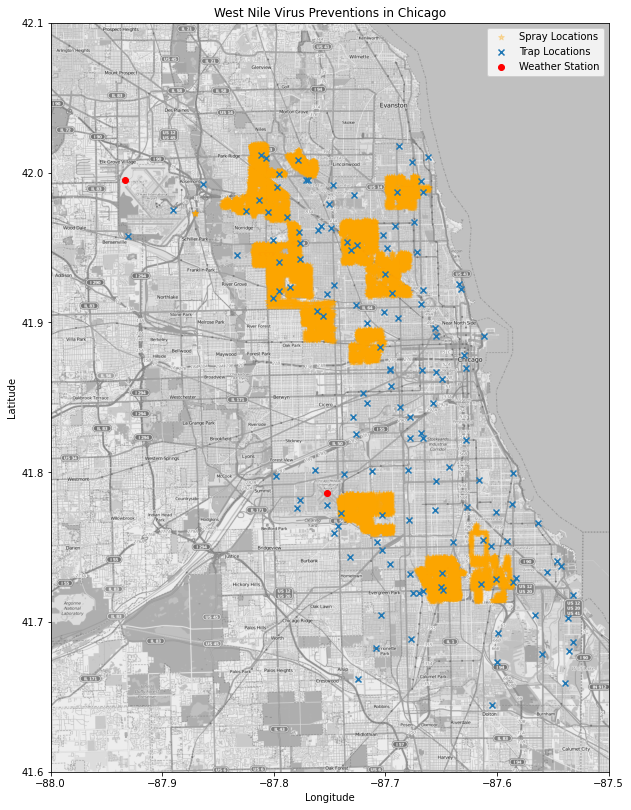

In [95]:
from sklearn.neighbors import KernelDensity

# Load map data
mapdata = np.loadtxt("data/mapdata_copyright_openstreetmap_contributors.txt")
traps = train[['date', 'trap','longitude', 'latitude', 'wnvpresent']]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

# Plot map
plt.figure(figsize=(10,14))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)

# Spray locations
sprays = spray[['longitude', 'latitude']].drop_duplicates()
sprays = sprays[sprays['latitude'] < 42.3]  #outliers excluded
plt.scatter(sprays['longitude'], sprays['latitude'], marker='*', color='orange',alpha=.3, label='Spray Locations')

# Trap locations
locations = traps[['longitude', 'latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='x', label='Trap Locations')

# Weather locations
plt.scatter(x = (-87.933, -87.752), y = (41.995, 41.786), marker='o', color='r', label='Weather Station')

            
plt.title('West Nile Virus Preventions in Chicago')
plt.legend(frameon=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('heatmap.png');

-------

# Predicting on number of mosquitos on test file

As you can see in test file which is use to predicting don't have nummosquitos. Therefore, we will create model to predict number of mosquitos by using previous data from train data to predict number of mosquitos in test file. By using train data and weather data.

In [96]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression,LogisticRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error

In [97]:
test = pd.read_csv('data/clean_test.csv')
train = pd.read_csv('data/clean_train.csv')
weather = pd.read_csv('data/clean_weather.csv')

- The column wnvpresent not have in test file because it's our target variable to predict
- Column nummosquitos is not present so we will predict it

In [98]:
set(train.columns)-set(test.columns)

{'nummosquitos', 'wnvpresent'}

Due to file weather file contain record of 2 stations we will merge it to be one row. By joining and using average value of it and drop out columns station

In [99]:
weather_both = pd.DataFrame()
station_1 = weather[weather['station'] == 1].reset_index()
station_2 = weather[weather['station'] == 2].reset_index()
weather_both['date'] = station_1['date']

def avg_station(df):
    for col in df:
        weather_both[col] = (station_1[col] + station_2[col])*.5
avg_station(weather.drop(['date','station'],axis=1))
weather = weather_both

Join train and test file with weather we have manage before.

In [100]:
train_df = pd.merge(train, weather, on = 'date', how = 'left')
test_df = pd.merge(test, weather, on = 'date', how = 'left')

Drop date and trap columns we no need to use these columns in model to predict number of mosquitos.

In [101]:
train_df.drop(columns=['date','trap'],inplace=True)

In [102]:
test_df.drop(columns=['date','trap'],inplace=True)

Getting dummy of both file train and test (which already join with weather) to convert category columns before take it into model.

In [103]:
train_df = pd.get_dummies(train_df)

In [104]:
test_df = pd.get_dummies(test_df)

Because we need to predict number in file test target variable (y) will be nummosquitos and the rest of it will be predictors.

In [105]:
X = train_df.drop(columns='nummosquitos')
y = train_df['nummosquitos']
X_test_file = test_df

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify =y)

Scale the data into the same range.

In [107]:
ss = StandardScaler()

In [108]:
X_train = ss.fit_transform(X_train)
X_test = ss.fit_transform(X_test)
X_test_file = ss.fit_transform(X_test_file)

# 1. Linear Regression

In [109]:
lr=LinearRegression()

In [110]:
lr.fit(X,y)
print('LR R2 Score:', lr.score(X_train,y_train))
print('LR R2 CV Score:', cross_val_score(lr,X_train,y_train,cv=5).mean())
print('LR RMSE Score:', np.abs(cross_val_score(lr,X,y,cv=5,scoring='neg_root_mean_squared_error').mean()))

LR R2 Score: -59422.012551593536
LR R2 CV Score: 0.10225794275460698
LR RMSE Score: 16.97197103830021


In [111]:
predict_mos_lr = lr.predict(X_test).tolist()

In [112]:
predict_mos_lr

[-3931.8693113378654,
 -3918.3143330667117,
 -3978.7027747031393,
 -3979.7809125069707,
 -3975.5368127855213,
 -3939.9268253317837,
 -3952.900607742356,
 -3965.320826855839,
 -4019.629989954723,
 -3963.5068140787225,
 -3966.213314999623,
 -3994.1177291083914,
 -3975.457547909488,
 -3968.399863571148,
 -3987.4646219464503,
 -3971.127098325031,
 -3924.746281657936,
 -3980.7714983517967,
 -3982.0771223183506,
 -3947.7173495827587,
 -3995.8706725715006,
 -8672.183343459134,
 -4018.875607715861,
 -3965.3728478012213,
 -4007.3693247739234,
 -3969.026605895705,
 -3997.2538336128155,
 -3954.564960544769,
 -3932.4868047931254,
 -3951.7507031016166,
 -3946.888232165695,
 -4030.320274029126,
 -3954.7871840632547,
 -4006.0857697703295,
 -3996.5353345909275,
 -4044.5929681333514,
 -3977.8928881437996,
 -3979.500244281737,
 -3968.5504377134953,
 -3984.6435512040657,
 -3938.496468118816,
 -3946.837125083016,
 -3997.639053019192,
 -3983.728209729942,
 -3911.4313698926508,
 -3961.452790040945,
 -3961.1

Score on Linear is actually bad. As you can see from predicting number of mosquitos is really bad millions of negative of number. We will try another model.

-----

# 2. Ridge

In [113]:
ridgeCV = RidgeCV(alphas=np.linspace(0.1,10,50))
ridgeCV.fit(X_train,y_train)
ridge = Ridge(alpha=(ridgeCV.alpha_))
ridge.fit(X_train,y_train)

Ridge(alpha=0.7061224489795919)

In [114]:
ridge.score(X_train,y_train)

0.11377129322316337

In [115]:
ridge.score(X_test,y_test)

0.10845272688125551

In [116]:
cross_val_score(ridge,X_train,y_train,cv=5).mean()

0.10176045549009387

In [117]:
# Error on train data
np.sqrt(mean_squared_error(y_train, ridge.predict(X_train)))

16.073735241509837

In [118]:
# Error on test data
np.sqrt(mean_squared_error(y_test, ridge.predict(X_test)))

15.766284968250355

In [119]:
predict_mos_ridge = ridge.predict(X_test_file).tolist()

In [120]:
predict_mos_ridge

[22.651254193299565,
 15.096165467205257,
 18.269812624753335,
 15.7464055170208,
 15.746335968695165,
 15.746266420369532,
 15.746196872043898,
 15.746127323718262,
 20.956866173172358,
 13.40177744707805,
 16.575424604626132,
 14.052017496893596,
 14.051947948567962,
 14.051878400242327,
 14.051808851916693,
 14.05173930359106,
 20.379807900995154,
 12.824719174900846,
 15.998366332448928,
 13.474959224716391,
 13.474889676390758,
 13.474820128065122,
 13.474750579739489,
 13.474681031413853,
 19.026800013442987,
 11.47171128734868,
 14.645358444896761,
 12.121951337164226,
 12.12188178883859,
 12.121812240512956,
 12.121742692187322,
 12.121673143861688,
 19.666655577790713,
 12.11156685169641,
 15.28521400924449,
 12.761806901511955,
 12.76173735318632,
 12.761667804860686,
 12.76159825653505,
 12.761528708209417,
 20.333739224589195,
 12.778650498494885,
 15.952297656042969,
 13.42889054831043,
 13.428820999984797,
 13.428751451659164,
 13.428681903333528,
 13.428612355007894,
 19

Number of mosquitos more reasonable we will compare with lasso model to determine which one we will choose to predict.

---

# 3. Lasso

In [121]:
l_alphas = np.arange(0.001, 0.15, 0.0025)

In [122]:
lasso = LassoCV()
lasso.fit(X, y)
l_alphas_best = lasso.alpha_
l_alphas_best 

C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 556.0110813558567, tolerance: 178.6463304373524
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 671.6615899910685, tolerance: 178.6463304373524
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 697.0821271399036, tolerance: 178.6463304373524
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: Conver

C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 227.62035991204903, tolerance: 171.13483247156157
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 281.8862085286528, tolerance: 171.13483247156157
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 286.5594682865776, tolerance: 171.13483247156157
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Co

0.09236254707650687

In [123]:
lasso.score(X_train, y_train)

-9776.33827300423

In [124]:
lasso.score(X_test, y_test)

-10220.62653133199

In [125]:
cross_val_score(lasso,X_train,y_train,cv=5).mean()

C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 504.08406092820223, tolerance: 119.53045014778326
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7100.606239423738, tolerance: 119.53045014778326
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 690.3340637383517, tolerance: 119.53045014778326
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: Co

C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15091.354798218585, tolerance: 114.8137514405319
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22786.756694803364, tolerance: 114.8137514405319
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28605.590223735664, tolerance: 114.8137514405319
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: Con

C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2248.8928917881567, tolerance: 123.36666678158088
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3044.0639564805897, tolerance: 123.36666678158088
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9802.519828654942, tolerance: 123.36666678158088
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: C

C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 464.29438451875467, tolerance: 118.85858374784539
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 171.20341355388518, tolerance: 118.85858374784539
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2459.497285378282, tolerance: 118.85858374784539
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: C

C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 493.7521925782785, tolerance: 115.71856852991873
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 385.44697394163813, tolerance: 115.71856852991873
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6058.278032823349, tolerance: 115.71856852991873
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: Co

C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 191.5419632785488, tolerance: 118.79449647869986
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6002.759058575146, tolerance: 118.79449647869986
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11531.883539163973, tolerance: 118.79449647869986
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: Co

C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 127915.13633649552, tolerance: 150.60699787234051
  model = cd_fast.enet_coordinate_descent(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133.0470144370338, tolerance: 116.19453586206897
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 324.6277506920742, tolerance: 116.19453586206897
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: Converg

0.10139757519090238

In [126]:
#Error on train data
np.sqrt(mean_squared_error(y_train, lasso.predict(X_train)))

1688.3178971565055

In [127]:
#Error on test data
np.sqrt(mean_squared_error(y_test, lasso.predict(X_test)))

1688.1739268387523

Lasso perform slightly bad when compare score and rmse with Ridge.

---

### Score of Ridge perform better 
- So, I will use Ridge to predict number of mosquitos on test file

In [128]:
test['nummosquitos'] = predict_mos_ridge

There are some inrelavant value number of mosquitos can't be negative. So I will map value which is negative to be 0.

In [129]:
test['nummosquitos'].describe()

count    116293.000000
mean         10.451379
std           5.901240
min         -18.989746
25%           6.869842
50%          10.736179
75%          14.419232
max          30.651230
Name: nummosquitos, dtype: float64

Mapping value of nummosquitos below 0 to be 0 by using clip

In [130]:
test['nummosquitos'] = test['nummosquitos'].clip(lower=0)

In [131]:
test['nummosquitos'].describe()

count    116293.000000
mean         10.610241
std           5.527934
min           0.000000
25%           6.869842
50%          10.736179
75%          14.419232
max          30.651230
Name: nummosquitos, dtype: float64

In [132]:
test['nummosquitos'] = round(test['nummosquitos'],0)

Export file to use in model and tuning.

In [133]:
test.to_csv('data/test_with_mosnum.csv',index=False)